### Object Detection via Semantic Segmentation

#### Import Modules

In [1]:
# IMPORT MODULES
# Import Import Numpy, TensorFlow, Scipy, Keras
import sys
import time
import os
import numpy as np 
import pandas as pd 
from glob import glob
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils import shuffle
import keras
from keras.datasets import cifar10
from keras.models import Sequential,model_from_json
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Convolution2D,MaxPooling2D
from keras.layers import Flatten,Lambda,ELU
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from sklearn.cross_validation import train_test_split
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import json
from keras.models import Sequential, model_from_json
print('Import Modules')

Import Modules


Using TensorFlow backend.


#### Load Data

In [2]:
# LOAD DATA
# Change Directory
os.chdir('..')

In [3]:
# LOAD DATA
# Find Files
all_paths = pd.DataFrame(dict(Path = glob(os.path.join('Data','*', '*.*p*g'))))
all_paths['Split'] = all_paths['Path'].map(lambda x: x.split('/')[-2].split('-')[0])
all_paths['Group'] = all_paths['Path'].map(lambda x: x.split('/')[-2].split('-')[-1])
all_paths['ID'] = all_paths['Path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))

In [4]:
# LOAD DATA
# Display Samples
all_paths.sample(5)

Path  Split  Group  \
1625      Data/Train-Color/170908_061515335_Camera_6.jpg  Train  Color   
38679     Data/Train-Color/171206_025937488_Camera_5.jpg  Train  Color   
6474      Data/Train-Color/170908_065053355_Camera_5.jpg  Train  Color   
17093     Data/Train-Color/170908_065045036_Camera_5.jpg  Train  Color   
73531  Data/Train-Label/170908_073300609_Camera_5_ins...  Train  Label   

                              ID  
1625   170908_061515335_Camera_6  
38679  171206_025937488_Camera_5  
6474   170908_065053355_Camera_5  
17093  170908_065045036_Camera_5  
73531  170908_073300609_Camera_5

In [5]:
# LOAD DATA
# Pivot Data
group_df = all_paths.pivot_table(values = 'Path', columns = 'Group', \
                                 aggfunc = 'first', index = ['ID', 'Split']).reset_index()

In [6]:
# LOAD DATA
# Display Samples
group_df.sample(5)

Group                         ID  Split  \
21424  170927_064057224_Camera_6  Train   
33648  171206_033135844_Camera_6  Train   
7360   170908_065641622_Camera_5  Train   
25736  170927_070444127_Camera_5  Train   
12033  170908_075005861_Camera_5  Train   

Group                                           Color  \
21424  Data/Train-Color/170927_064057224_Camera_6.jpg   
33648  Data/Train-Color/171206_033135844_Camera_6.jpg   
7360   Data/Train-Color/170908_065641622_Camera_5.jpg   
25736  Data/Train-Color/170927_070444127_Camera_5.jpg   
12033  Data/Train-Color/170908_075005861_Camera_5.jpg   

Group                                              Label  
21424  Data/Train-Label/170927_064057224_Camera_6_ins...  
33648  Data/Train-Label/171206_033135844_Camera_6_ins...  
7360   Data/Train-Label/170908_065641622_Camera_5_ins...  
25736  Data/Train-Label/170927_070444127_Camera_5_ins...  
12033  Data/Train-Label/170908_075005861_Camera_5_ins...

In [7]:
# LOAD DATA
# Load Training Data Files
training_data_files = group_df.query('Split=="Train"')
data_size = training_data_files.shape[0]
print('Size of Training Data', data_size)

Size of Training Data 39222


#### Explore Data

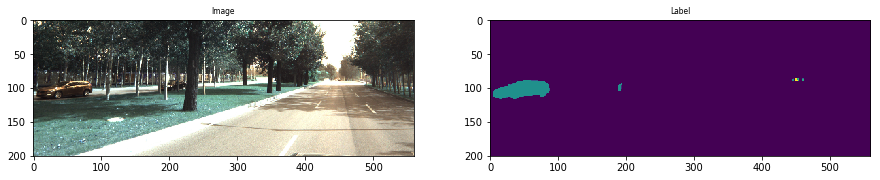

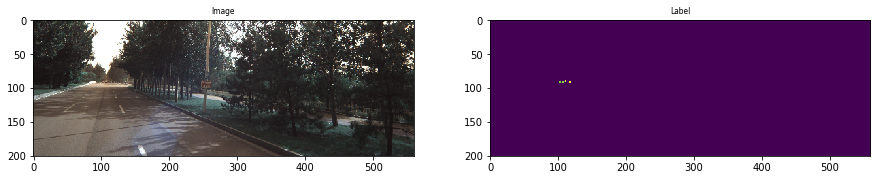

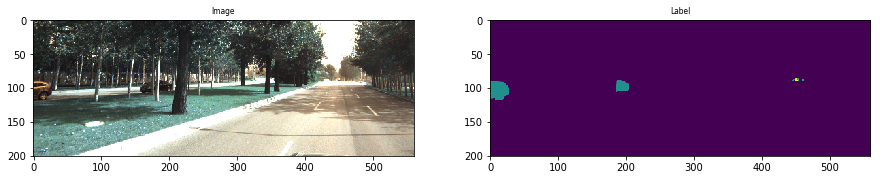

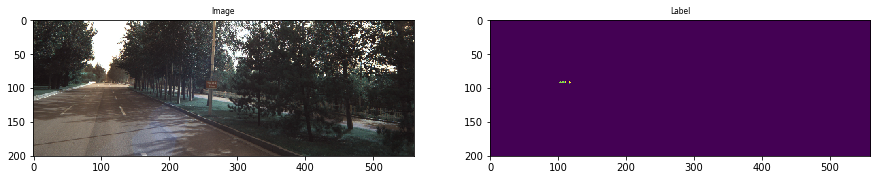

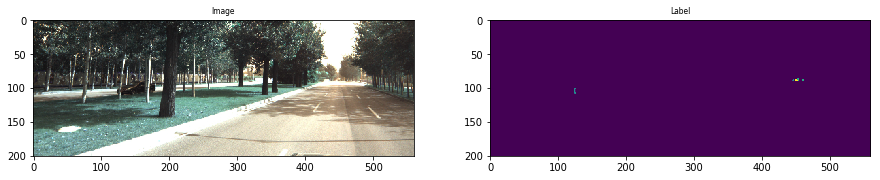

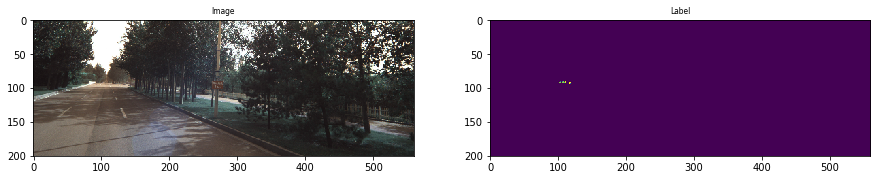

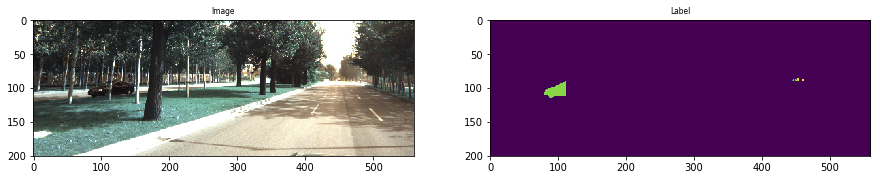

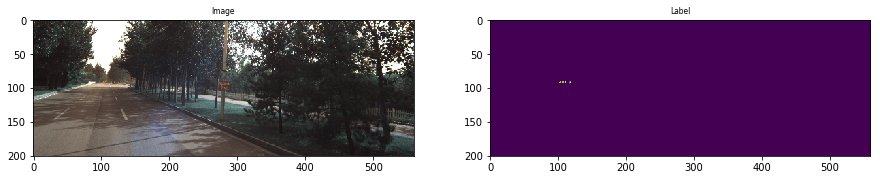

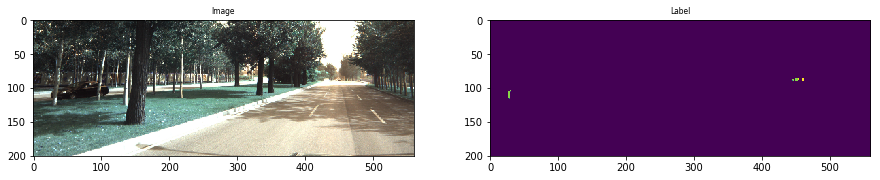

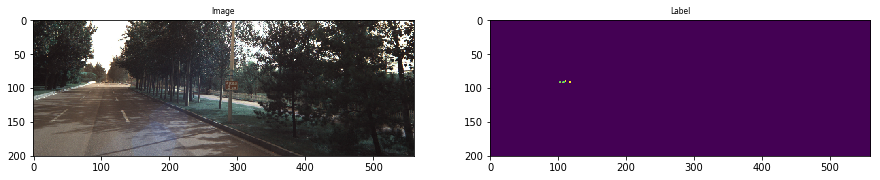

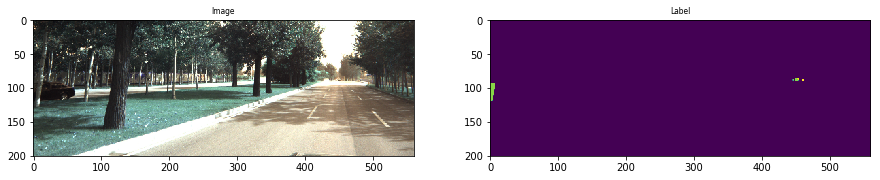

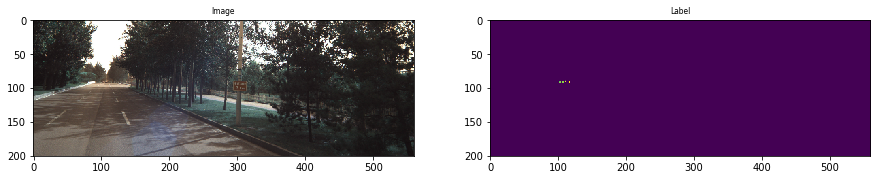

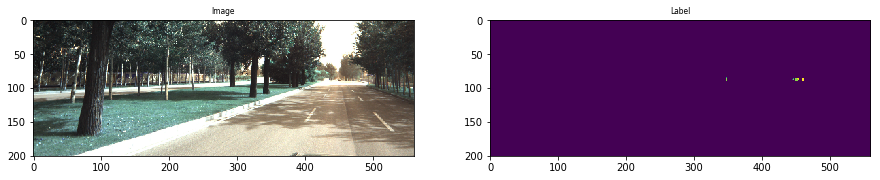

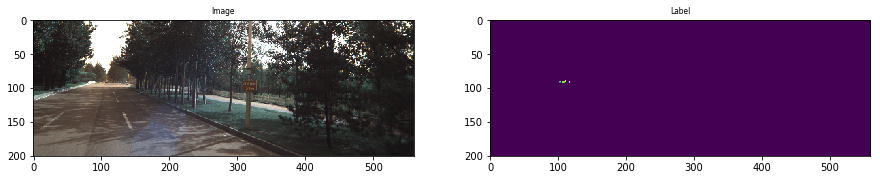

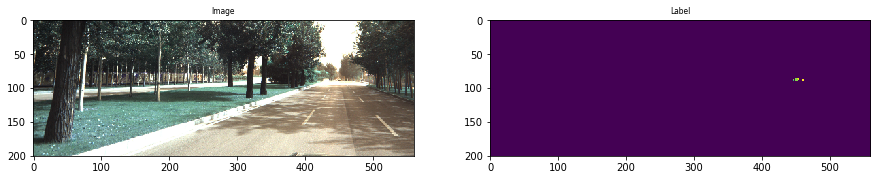

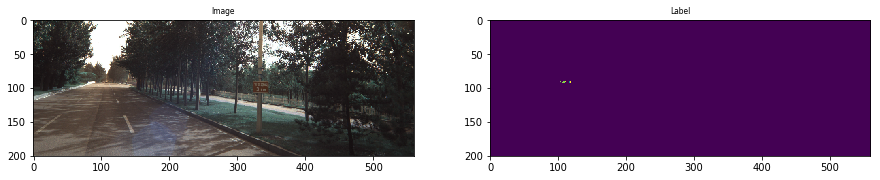

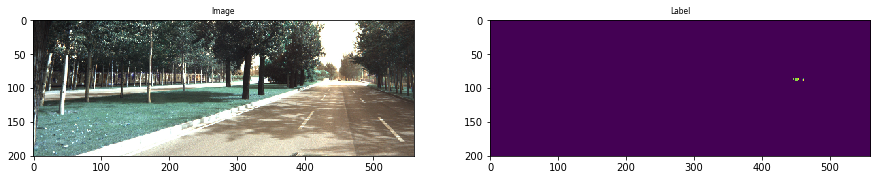

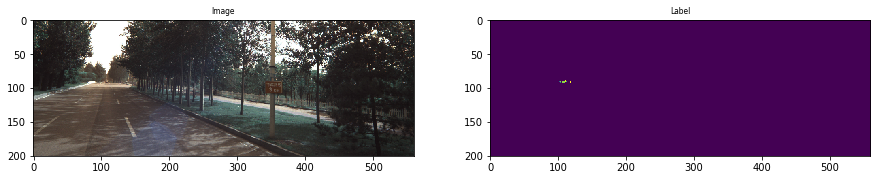

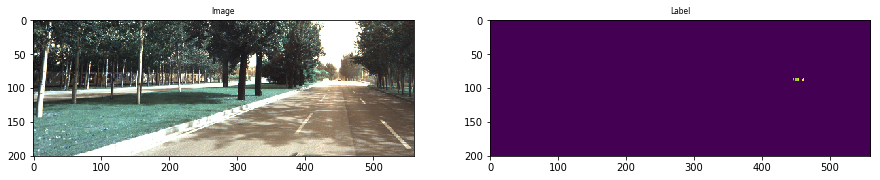

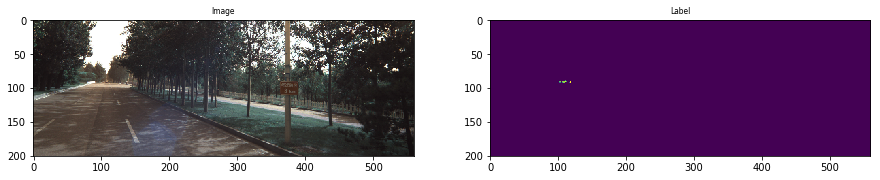

In [9]:
# EXPLORE DATA
# Load Images in Loop and Display
for i in range(10,30):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x100
    input_img = cv2.resize(input_img, (560, 200))
    label_img = cv2.resize(label_img, (560, 200))
    
    # Plot
    fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,15))
    axis1.imshow(input_img)
    axis1.set_title('Image',fontsize=7.5)
    axis2.imshow(label_img)
    axis2.set_title('Label',fontsize=7.5)

#### Preprocess Data

In [10]:
# PREPROCESS DATA
# Clear Memory
del all_paths
del group_df

In [11]:
# PREPROCESS DATA
# Load Input Images
x_train = []
for i in range(10000):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    
    # Resize Image to 100x280
    input_img = cv2.resize(input_img, (144, 144))
    
    # Flatten Image and Append 
    image_flat = input_img.flatten().tolist()
    x_train += image_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
image_feature_size=int(len(x_train))
print("Feature Size:", image_feature_size)

# Revert to the Original Image Shapes
x_train = np.array(x_train).reshape(10000, 144, 144, 3)
print("Feature Size:", x_train.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Images Loaded: 2000
Images Loaded: 2100
Images Loaded: 2200
Images Loaded: 2300
Images Loaded: 2400
Images Loaded: 2500
Images Loaded: 2600
Images Loaded: 2700
Images Loaded: 2800
Images Loaded: 2900
Images Loaded: 3000
Images Loaded: 3100
Images Loaded: 3200
Images Loaded: 3300
Images Loaded: 3400
Images Loaded: 3500
Images Loaded: 3600
Images Loaded: 3700
Images Loaded: 3800
Images Loaded: 3900
Images Loaded: 4000
Images Loaded: 4100
Images Loaded: 4200
Images Loaded: 4300
Images Loaded: 4400
Images Loaded: 4500
Images Loaded: 4600
Images Loaded: 4700
Images Loaded: 4800
Images Loaded: 4900
Images Loade

In [12]:
# PREPROCESS DATA
# Load Label Images
y_train = []
for i in range(10000):
    # Load Images
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x280
    label_img = cv2.resize(label_img, (144, 144))
    
    # Flatten Image and Append 
    label_flat = label_img.flatten().tolist()
    y_train += label_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
label_feature_size=int(len(y_train))
print("Feature Size:", label_feature_size)

# Revert to the Original Image Shapes
y_train = np.array(y_train).reshape(10000, 144, 144, 1)
print("Feature Size:", y_train.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Images Loaded: 2000
Images Loaded: 2100
Images Loaded: 2200
Images Loaded: 2300
Images Loaded: 2400
Images Loaded: 2500
Images Loaded: 2600
Images Loaded: 2700
Images Loaded: 2800
Images Loaded: 2900
Images Loaded: 3000
Images Loaded: 3100
Images Loaded: 3200
Images Loaded: 3300
Images Loaded: 3400
Images Loaded: 3500
Images Loaded: 3600
Images Loaded: 3700
Images Loaded: 3800
Images Loaded: 3900
Images Loaded: 4000
Images Loaded: 4100
Images Loaded: 4200
Images Loaded: 4300
Images Loaded: 4400
Images Loaded: 4500
Images Loaded: 4600
Images Loaded: 4700
Images Loaded: 4800
Images Loaded: 4900
Images Loade

In [13]:
# PREPROCESS DATA
# Load Input Images
x_valid = []
for i in range(2000):
    # Load Images
    input_img = cv2.imread(training_data_files['Color'][i])
    
    # Crop
    input_img = input_img[1200:2400,:]
    
    # Resize Image to 100x280
    input_img = cv2.resize(input_img, (144, 144))
    
    # Flatten Image and Append 
    image_flat = input_img.flatten().tolist()
    x_valid += image_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
image_feature_size=int(len(x_valid))
print("Feature Size:", image_feature_size)

# Revert to the Original Image Shapes
x_valid = np.array(x_valid).reshape(2000, 144, 144, 3)
print("Feature Size:", x_valid.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Feature Size: 124416000
Feature Size: (2000, 144, 144, 3)


In [14]:
# PREPROCESS DATA
# Load Label Images
y_valid = []
for i in range(2000):
    # Load Images
    label_img = cv2.imread(training_data_files['Label'][i])
    
    # Crop
    label_img = label_img[1200:2400,:]
    
    # Convert to Grayscale
    label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
    
    # Resize Image to 100x280
    label_img = cv2.resize(label_img, (144, 144))
    
    # Flatten Image and Append 
    label_flat = label_img.flatten().tolist()
    y_valid += label_flat
    
    # Check Progress
    if (i%100 == 0):
        print('Images Loaded:', i)

# Check Size of Data
label_feature_size=int(len(y_valid))
print("Feature Size:", label_feature_size)

# Revert to the Original Image Shapes
y_valid = np.array(y_valid).reshape(2000, 144, 144, 1)
print("Feature Size:", y_valid.shape)

Images Loaded: 0
Images Loaded: 100
Images Loaded: 200
Images Loaded: 300
Images Loaded: 400
Images Loaded: 500
Images Loaded: 600
Images Loaded: 700
Images Loaded: 800
Images Loaded: 900
Images Loaded: 1000
Images Loaded: 1100
Images Loaded: 1200
Images Loaded: 1300
Images Loaded: 1400
Images Loaded: 1500
Images Loaded: 1600
Images Loaded: 1700
Images Loaded: 1800
Images Loaded: 1900
Feature Size: 41472000
Feature Size: (2000, 144, 144, 1)


In [15]:
# PREPROCESS DATA
# Clear Memory
del training_data_files

#### Create Model

In [16]:
# CREATE MODEL
# Define a Function for Convolutional Block
def convolutional_block(input_tensor, depth, kernel, strides=(1, 1), padding="SAME", batchnorm = False):
    layer = tf.layers.conv2d(input_tensor, \
                             filters = depth, \
                             kernel_size = kernel, \
                             strides = strides, \
                             padding = padding, \
                             activation = tf.nn.relu)
    if batchnorm:
        layer = tf.layers.batch_normalization(layer, training = False)
        
    return layer

In [17]:
# CREATE MODEL
# Define a Function for Deconvolutional Block
def deconvolutional_block(input_tensor, filter_size, output_size, \
             out_channels, in_channels, \
             strides = [1, 1, 1, 1], name = False):
    input_shape = tf.shape(input_tensor)
    batch_size = input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    weights = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05))
    if name: 
        layer = tf.nn.conv2d_transpose(input_tensor, weights, out_shape, strides, padding = 'SAME', name = 'y_pred')
    else:
        layer = tf.nn.conv2d_transpose(input_tensor, weights, out_shape, strides, padding = 'SAME')
    return layer

In [18]:
# CREATE MODEL
# Define a Function for Architecture
def UNet(x, n_filters):
    c1_a = convolutional_block(x, 16 * n_filters, 3) 
    c1 = convolutional_block(c1_a, 16 * n_filters, 3) 
    c1 = tf.nn.max_pool(value=c1,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')

    c2_a = convolutional_block(c1, 32 * n_filters, 3) 
    c2 = convolutional_block(c2_a, 32 * n_filters, 3)
    c2 = tf.nn.max_pool(value=c2,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')

    c3_a = convolutional_block(c2, 64 * n_filters, 3) 
    c3 = convolutional_block(c3_a, 64 * n_filters, 3) 
    c3 = tf.nn.max_pool(value=c3,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')


    c4_a = convolutional_block(c3, 128 * n_filters, 3) 
    c4 = convolutional_block(c4_a, 128 * n_filters, 3) 
    c4 = tf.nn.max_pool(value=c4,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')

    c5_a = convolutional_block(c4, 256 * n_filters, 3) 
    c5 = convolutional_block(c5_a, 256 * n_filters, 3) 

    d1 = deconvolutional_block(c5, 2, 18, 128 * n_filters, 256 * n_filters, strides=[1, 2, 2, 1]) 
    cat1 = tf.concat([d1, c4_a], 3)
    cat1 = convolutional_block(cat1, 128 * n_filters, 3) 
    cat1 = convolutional_block(cat1, 128 * n_filters, 3) 

    d2 = deconvolutional_block(cat1, 2, 36, 64 * n_filters, 128 * n_filters, strides=[1, 2, 2, 1]) 
    cat2 = tf.concat([d2, c3_a], 3)
    cat2 = convolutional_block(cat2, 64 * n_filters, 3) 
    cat2 = convolutional_block(cat2, 64 * n_filters, 3) 

    d3 = deconvolutional_block(cat2, 2, 72, 32 * n_filters, 64 * n_filters, strides=[1, 2, 2, 1]) 
    cat3 = tf.concat([d3, c2_a], 3)
    cat3 = convolutional_block(cat3, 32 * n_filters, 3) 
    cat3 = convolutional_block(cat3, 32 * n_filters, 3) 

    d4 = deconvolutional_block(cat3, 2, 144, 16 * n_filters, 32 * n_filters, strides=[1, 2, 2, 1]) 
    cat4 = tf.concat([d4, c1_a], 3)
    cat4 = convolutional_block(cat4, 16 * n_filters, 3) 
    cat4 = convolutional_block(cat4, 16 * n_filters, 3) 

    y_pred = deconvolutional_block(d4, 1, 144, 1, 16 * n_filters, name = True)
    
    return y_pred

#### Configure GPU

In [19]:
# CONFIGURE GPU
# Configure
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type='BFC'
config.gpu_options.per_process_gpu_memory_fraction=0.80

#### Train

In [20]:
# TRAIN
# Set Placeholder
x = tf.placeholder(tf.float32, shape=[None, 144, 144, 3], name = 'x')
y = tf.placeholder(tf.float32, [None, 144, 144, 1], name = 'y')

print("Setting Placeholder")

Setting Placeholder


In [21]:
# TRAIN
# Set Training Pipeline
rate = 0.00001
batch_size = 8
epochs = 5000
y_pred = UNet(x,2)
loss_operation = tf.losses.mean_squared_error(y, y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

print("Setting Training Pipeline")

Setting Training Pipeline


In [22]:
# TRAIN  
# Initialize Evaluation
correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define Evaluation 
def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run([loss_operation, training_operation], feed_dict={x:batch_x, y:batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy/num_examples

In [ ]:
# TRAIN 
# Initialize Saver
saver = tf.train.Saver()

# Use Session to Test Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    print("Training...")
    for i in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            loss_value, _ = sess.run([loss_operation, training_operation], feed_dict={x:batch_x, y:batch_y})   
        print("Epoch {} ...".format(i+1))
        print("Training Loss = {:.3f}".format(loss_value))  
        saver.save(sess,'./Model-Tensorflow/unet')
        print("Model Saved")

#### Evaluate

In [24]:
# TEST
# Define a Function to Convert Label Image to Binary Image
def threshold_labels(img, thresh):
    # Create Binary Image
    binary_img = np.zeros((img.shape[0], img.shape[1]))
    # Create For Loops for Check ground Pixels
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] > thresh:
                binary_img[i,j] = 255
            else:
                binary_img[i,j] = 0
    return binary_img

INFO:tensorflow:Restoring parameters from Model-Tensorflow/unet
Computation Time: 0.045507192611694336
Computation Time: 0.0029942989349365234
Computation Time: 0.0029761791229248047
Computation Time: 0.002953767776489258


/home/avidbots/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/avidbots/.local/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Computation Time: 0.0030601024627685547
Computation Time: 0.0029954910278320312
Computation Time: 0.003101348876953125
Computation Time: 0.002995014190673828
Computation Time: 0.0031375885009765625
Computation Time: 0.003037691116333008
Computation Time: 0.0030221939086914062
Computation Time: 0.0030531883239746094
Computation Time: 0.003300905227661133
Computation Time: 0.0029430389404296875
Computation Time: 0.0029888153076171875
Computation Time: 0.0029451847076416016
Computation Time: 0.003222942352294922
Computation Time: 0.002951383590698242
Computation Time: 0.0030264854431152344
Computation Time: 0.002946615219116211
Computation Time: 0.003064870834350586
Computation Time: 0.0029485225677490234
Computation Time: 0.0031490325927734375
Computation Time: 0.002960681915283203


/home/avidbots/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Computation Time: 0.0029976367950439453
Computation Time: 0.0029811859130859375
Computation Time: 0.002962350845336914
Computation Time: 0.0030210018157958984
Computation Time: 0.0030329227447509766
Computation Time: 0.0029294490814208984
Computation Time: 0.003072500228881836
Computation Time: 0.0029468536376953125
Computation Time: 0.003213644027709961
Computation Time: 0.002887248992919922
Computation Time: 0.002988576889038086
Computation Time: 0.002933979034423828
Computation Time: 0.0032110214233398438
Computation Time: 0.0029108524322509766
Computation Time: 0.0030634403228759766
Computation Time: 0.0029642581939697266
Computation Time: 0.0032880306243896484
Computation Time: 0.0029380321502685547
Computation Time: 0.002969503402709961
Computation Time: 0.0029921531677246094
Computation Time: 0.0032112598419189453
Computation Time: 0.003034353256225586
Computation Time: 0.0029973983764648438
Computation Time: 0.002932310104370117
Computation Time: 0.0030345916748046875
Computati

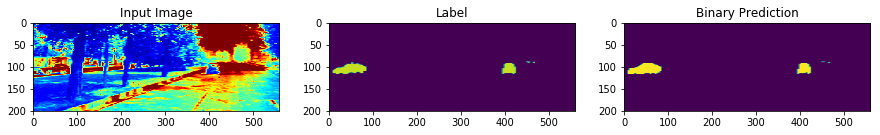

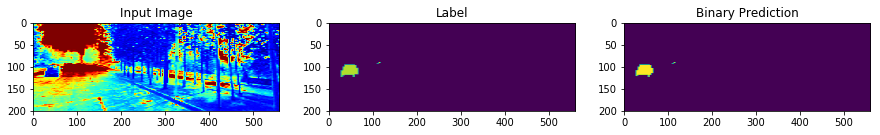

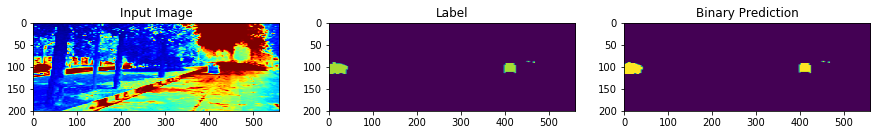

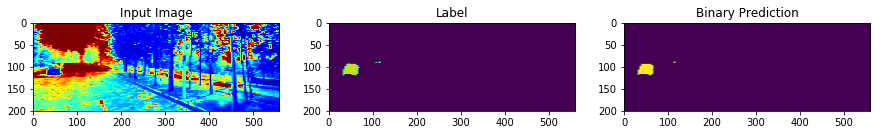

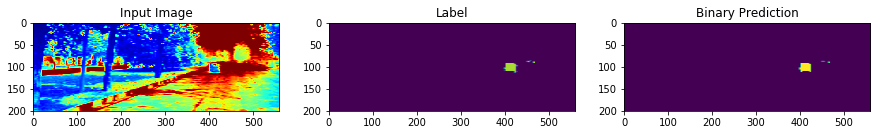

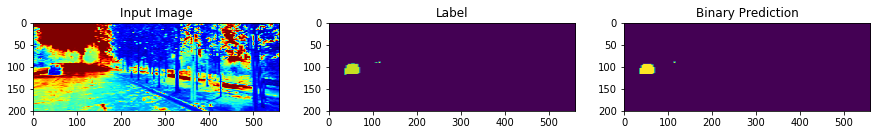

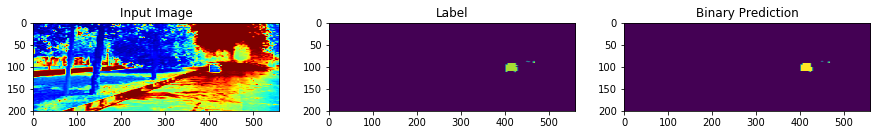

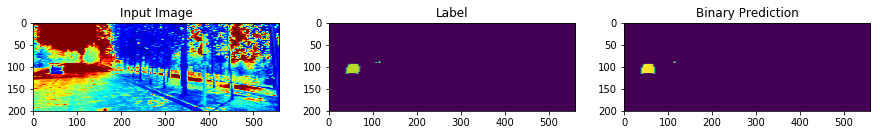

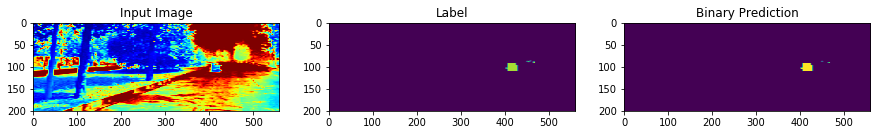

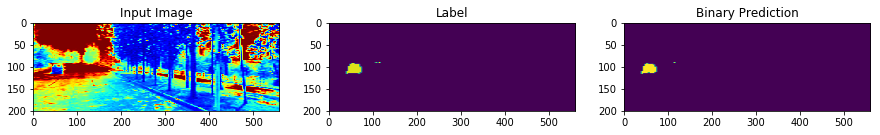

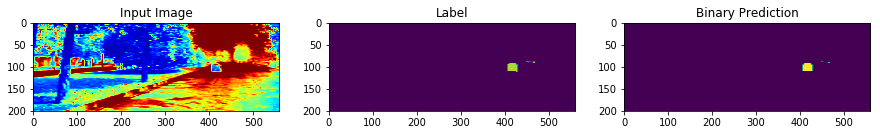

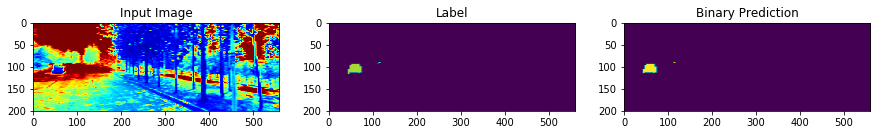

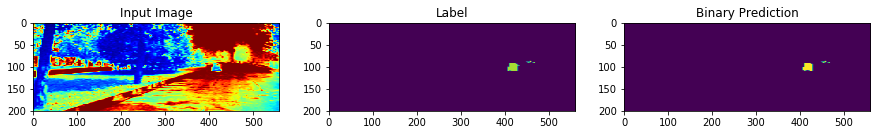

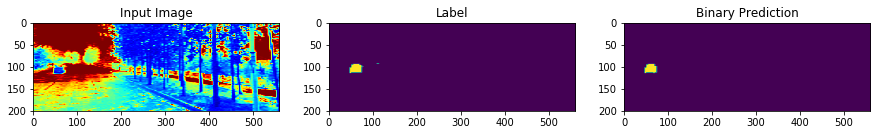

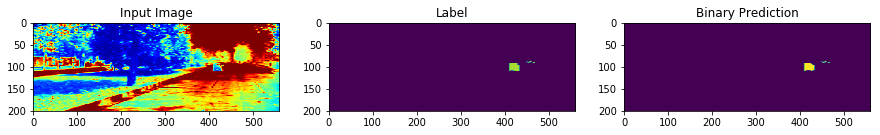

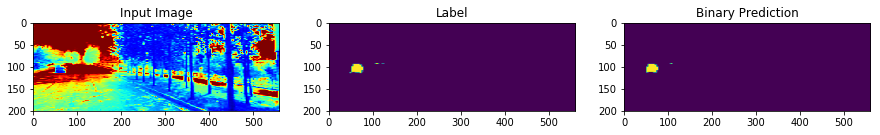

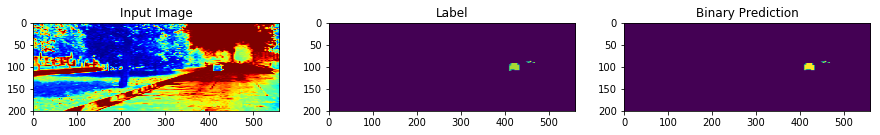

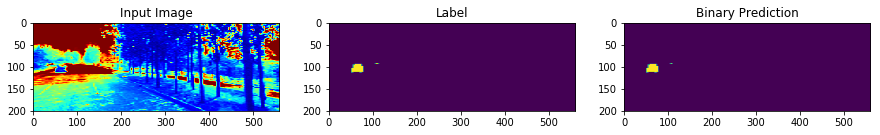

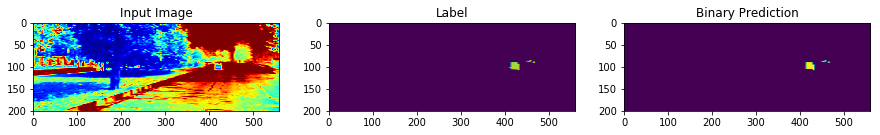

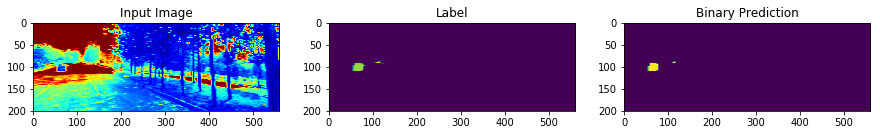

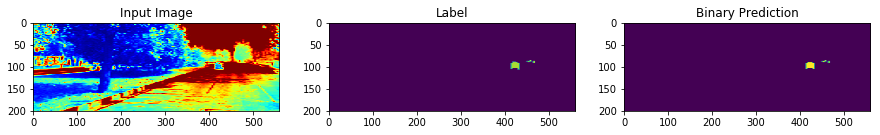

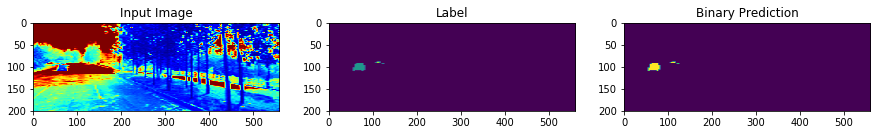

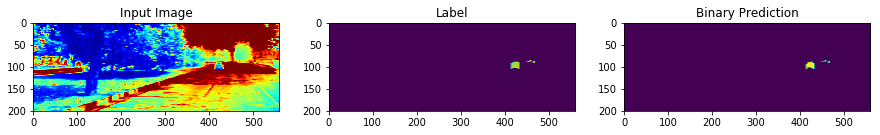

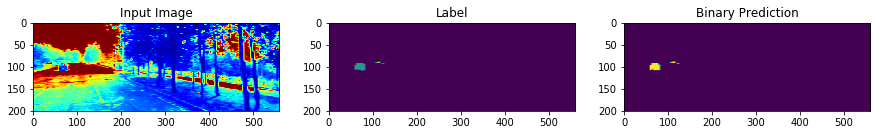

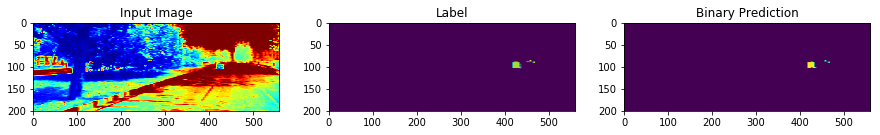

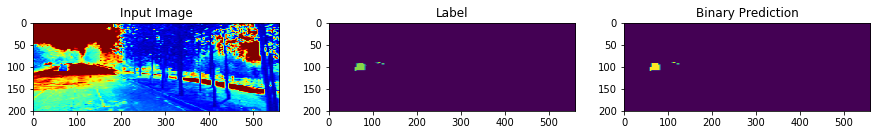

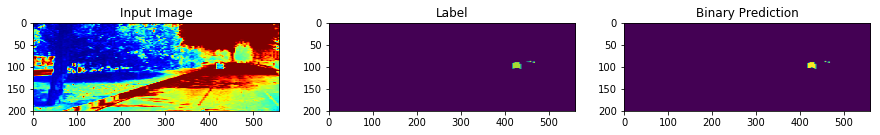

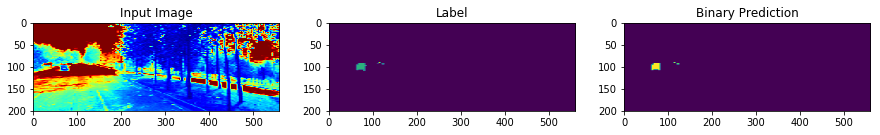

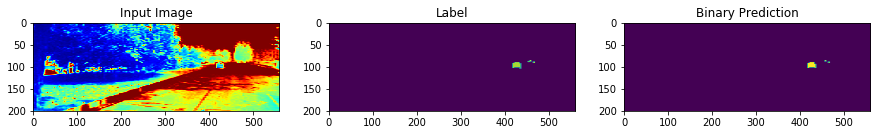

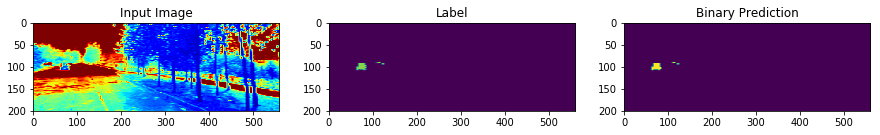

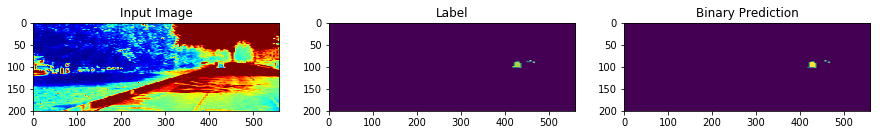

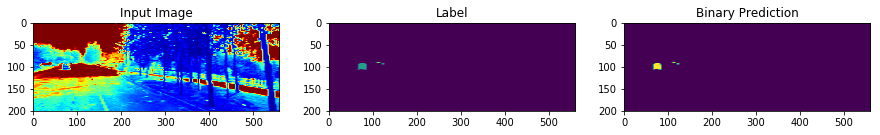

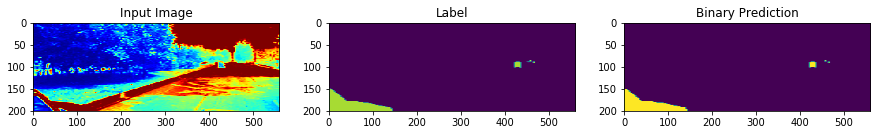

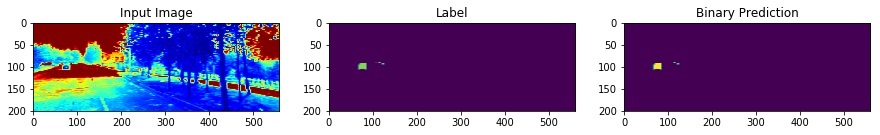

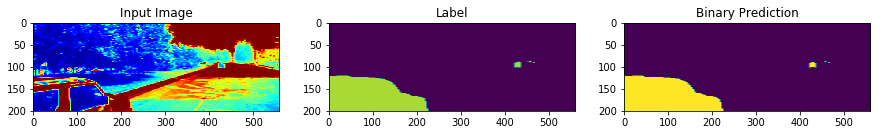

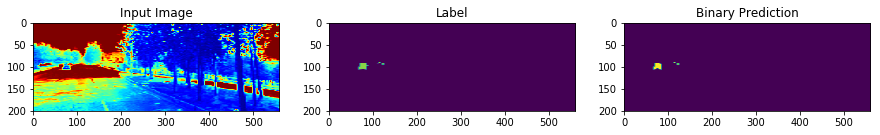

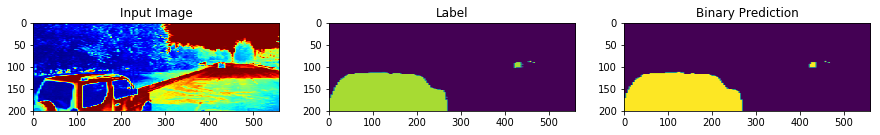

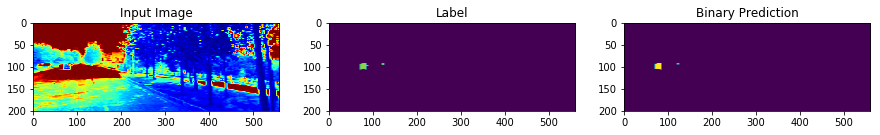

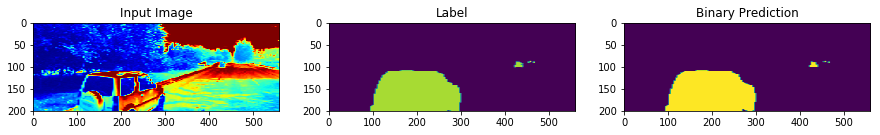

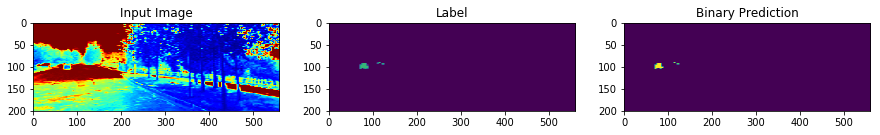

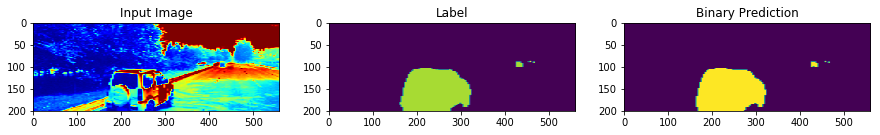

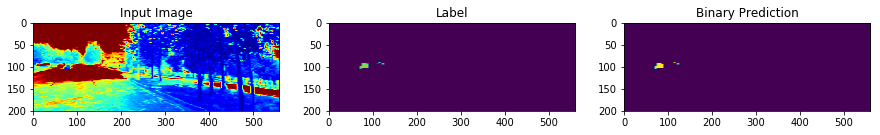

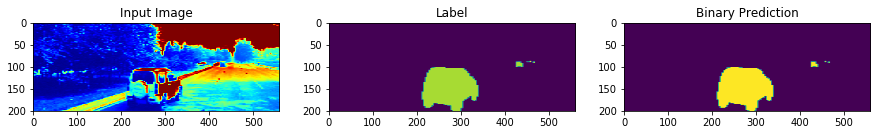

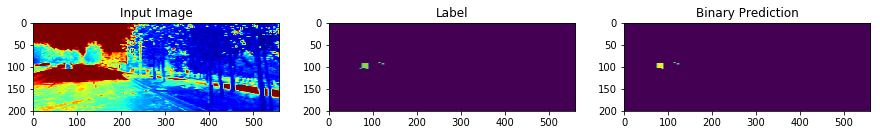

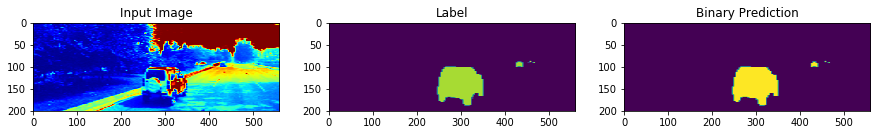

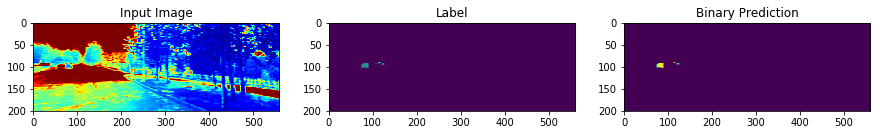

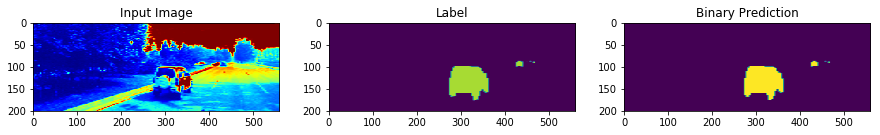

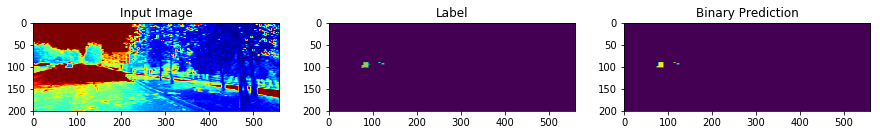

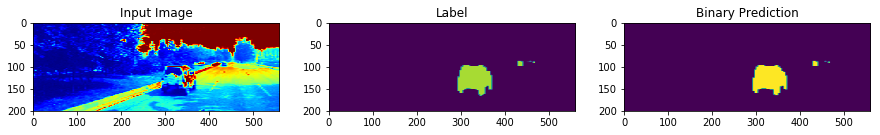

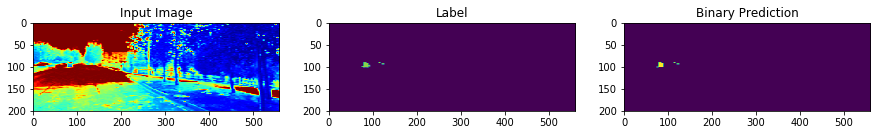

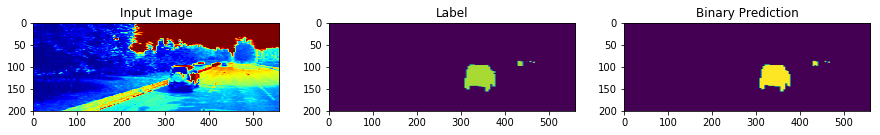

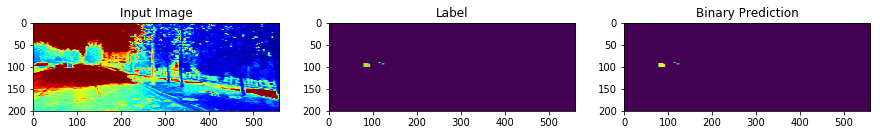

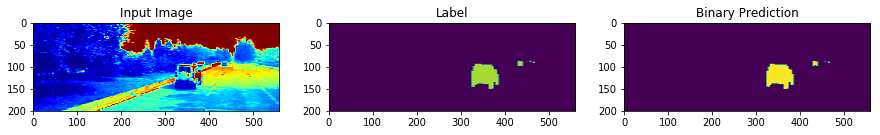

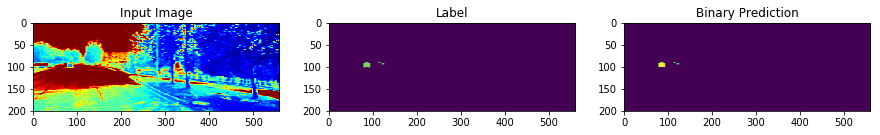

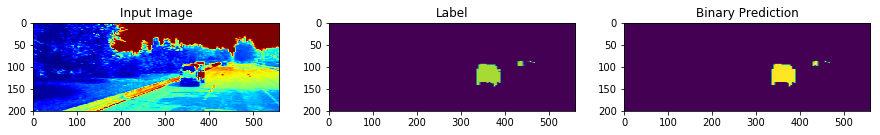

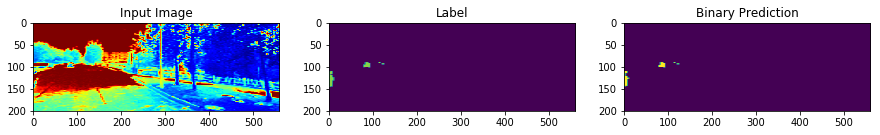

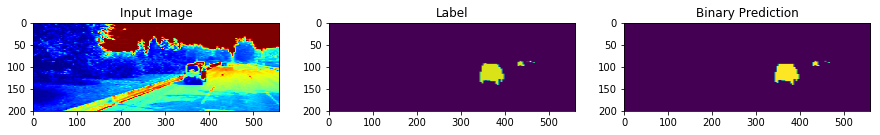

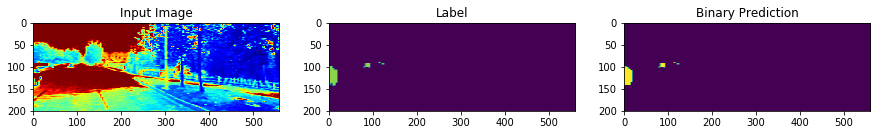

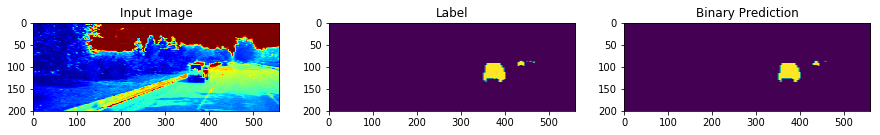

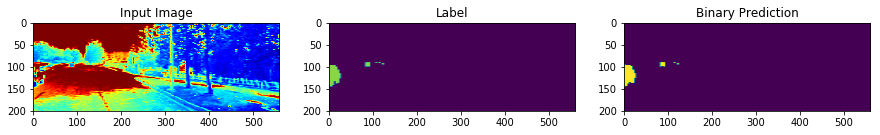

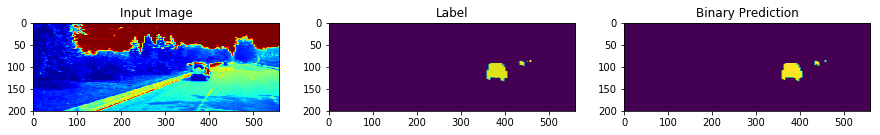

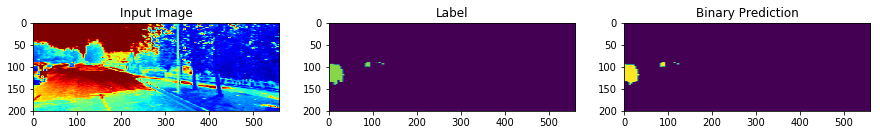

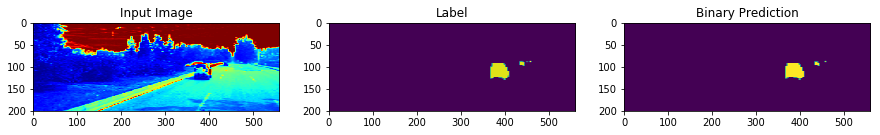

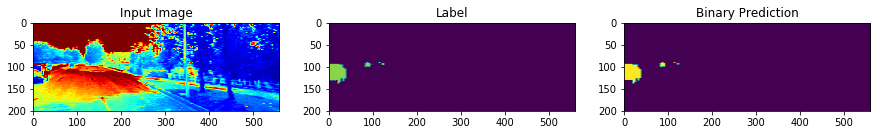

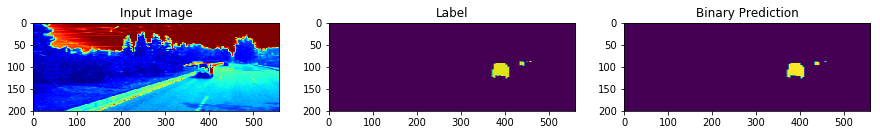

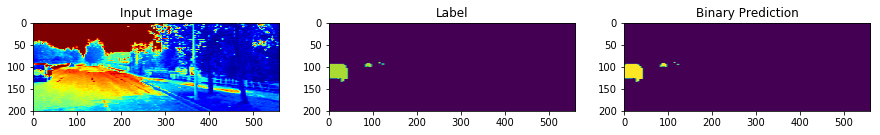

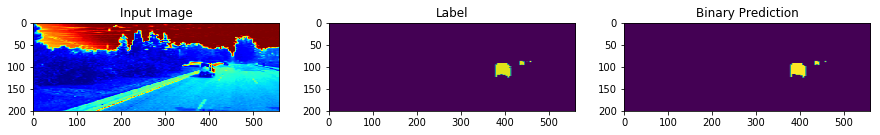

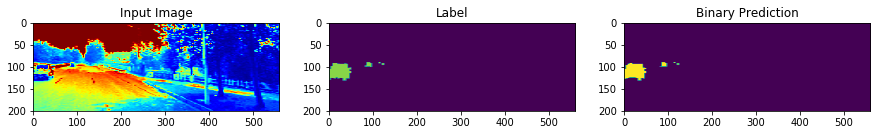

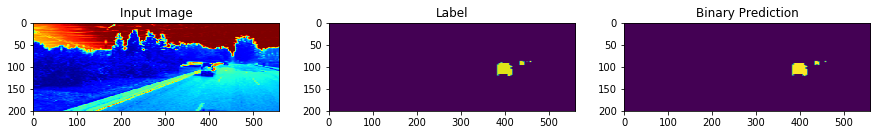

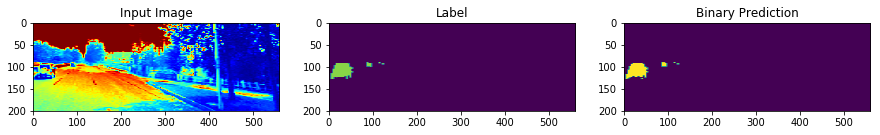

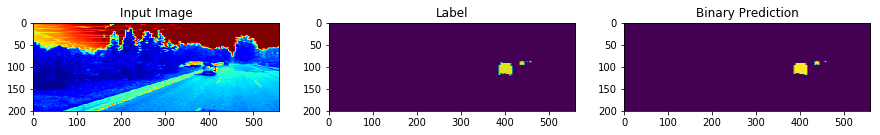

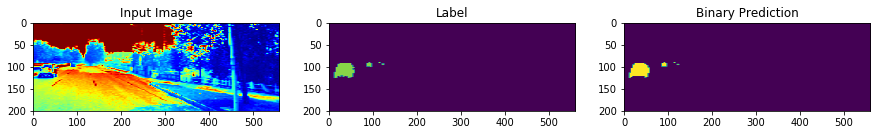

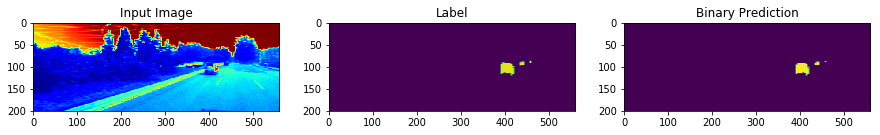

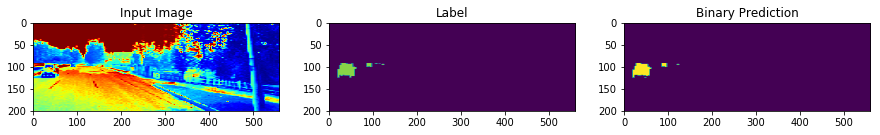

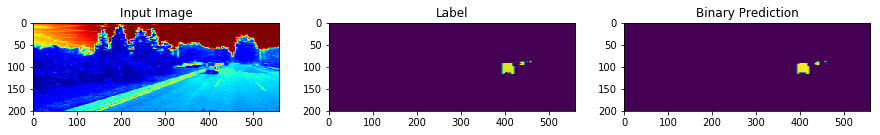

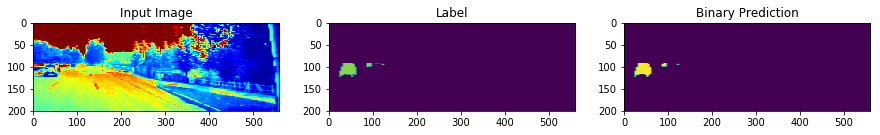

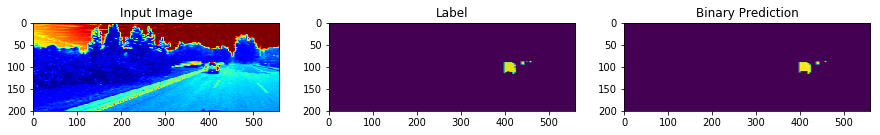

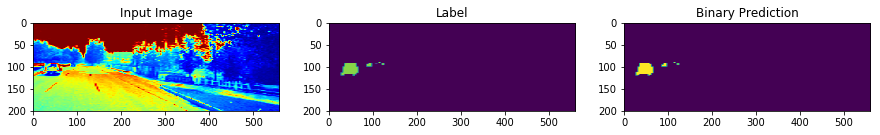

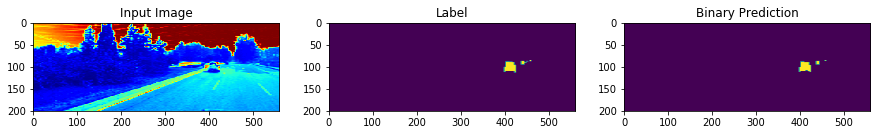

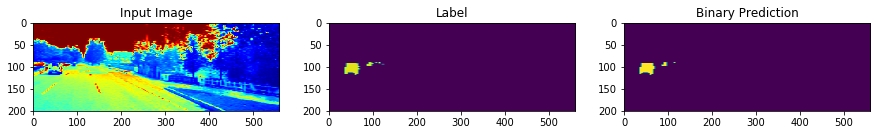

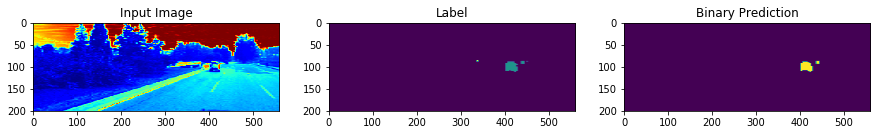

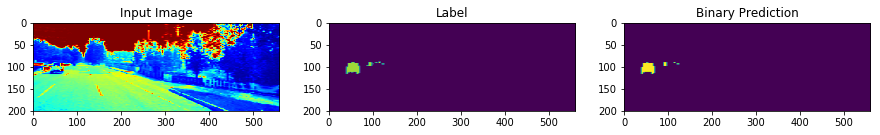

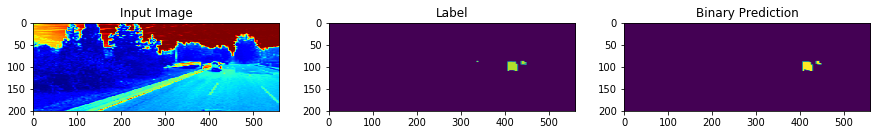

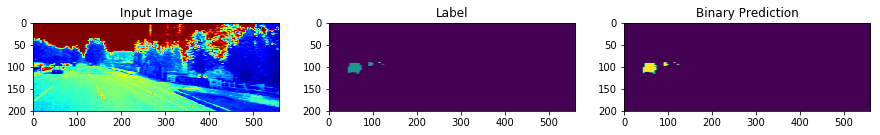

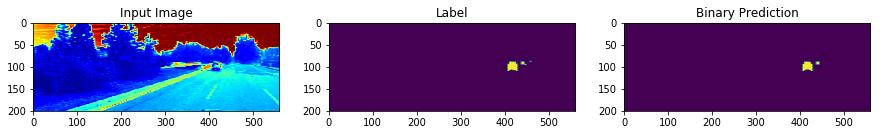

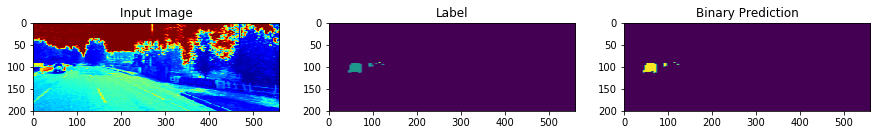

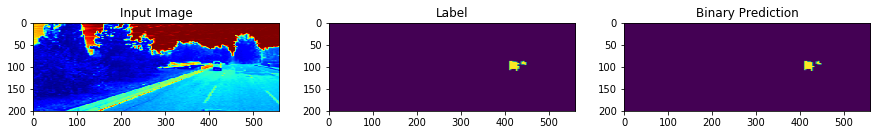

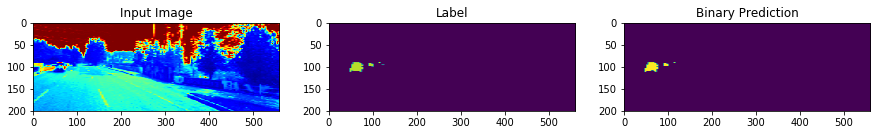

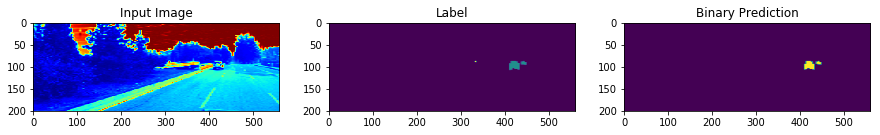

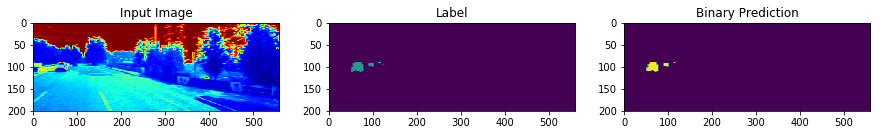

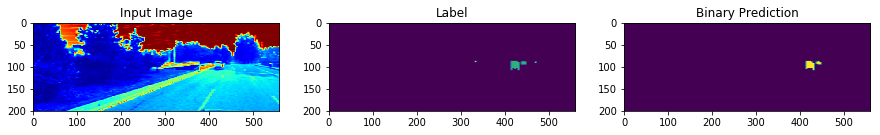

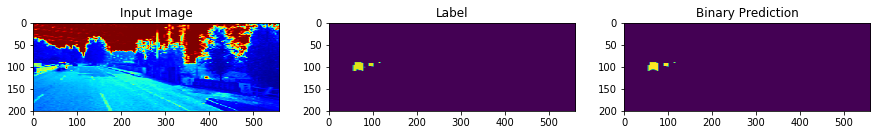

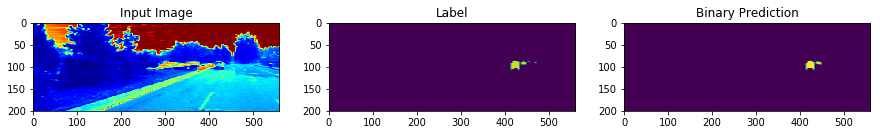

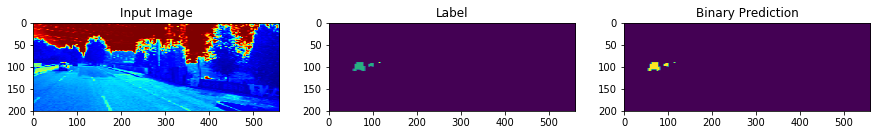

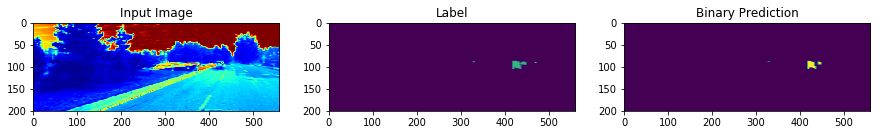

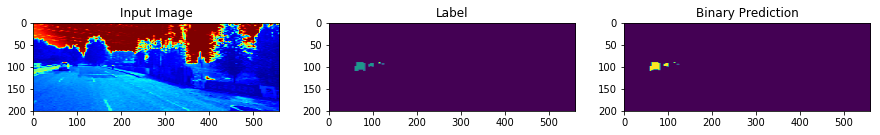

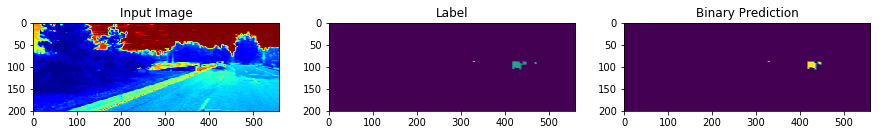

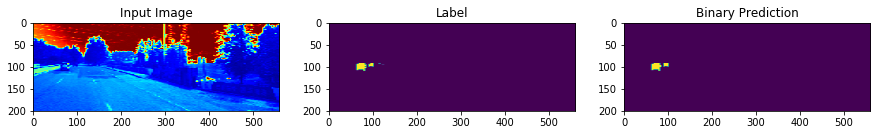

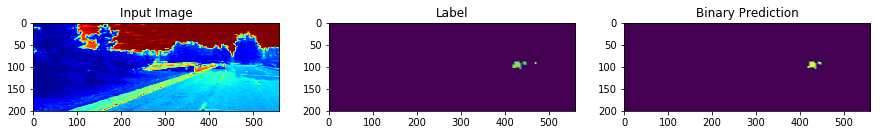

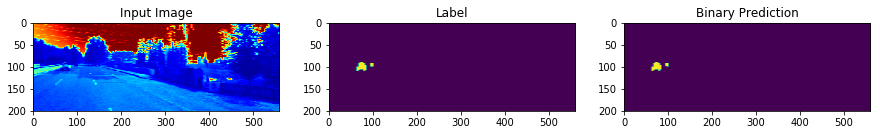

In [30]:
# Evaluate the Model on Random Images
import time
# Use Session to Infer
with tf.Session() as sess:
    saver.restore(sess,'Model-Tensorflow/unet')
    for i in range(100,200):
        # Predict
        original_image = x_valid[i]
        img = x_valid[i]
        label_image = y_valid[i]
        start_time = time.time()
        original_image = np.reshape(original_image, [-1, 144, 144, 3])
        test_data = {x:original_image}
        test_mask = sess.run([y_pred],feed_dict=test_data)
        test_mask = np.reshape(test_mask, (144,144))
        end_time = time.time()
        print('Computation Time:', end_time - start_time)
        binary_image = threshold_labels(test_mask, 100)
        
        # Resize Image
        img = resize(img, (200, 560), anti_aliasing=True)
        label_image = resize(label_image, (200, 560), anti_aliasing=True)
        binary_image = resize(binary_image, (200, 560), anti_aliasing=True)
    
        # Plot
        fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (15,15))
        axis1.imshow(img[:,:,0], cmap = 'jet')
        axis1.set_title('Input Image')
        axis2.imshow(label_image[:,:,0])
        axis2.set_title('Label')
        axis3.imshow(binary_image)
        axis3.set_title('Binary Prediction')